In [1]:
import torch
from torch import nn
import torch.nn.functional as F 

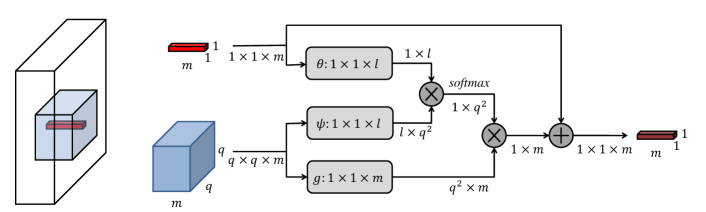

In [2]:
class non_local_module(nn.Module):
    def __init__(self, in_channels, filter_num, output_filter_num, field_size) -> None:
        super().__init__()
        self.theta = nn.Conv2d(in_channels, filter_num, kernel_size=1, stride=1, padding=0)
        self.phi = nn.Conv2d(in_channels, filter_num, kernel_size=1, stride=1, padding=0)
        self.g = nn.Conv2d(in_channels, output_filter_num, kernel_size=1, stride=1, padding=0)
        self.field_size = field_size
        
    def forward(self, x):
        x_theta = self.theta(x)
        x_phi = self.phi(x)
        x_g = self.g(x)
        
        # reshape and transpose
        x_theta_reshaped = x_theta.view(x_theta.size(0), x_theta.size(1), -1)
        print(f'x_theta_reshape shape : {x_theta_reshaped.size()}')
        x_phi_reshaped = x_phi.view(x_phi.size(0), x_phi.size(1), -1)
        print(f'x_phi_reshaped shape : {x_phi_reshaped.size()}')
        x_phi_permuted = x_phi_reshaped.permute(0, 2, 1)
        print(f'x_phi_permuted shape : {x_phi_permuted.size()}')
        
        # compute output
        x_mul1 = torch.bmm(x_theta_reshaped, x_phi_permuted)
        print(f'x_mul1 shape : {x_mul1.size()}')
        x_mul1_softmax = F.softmax(x_mul1, dim=-1)
        
        # g_path
        x_g_reshaped = x_g.view(x_g.size(0), x_g.size(1), -1)
        print(f'x_g_reshaped shape : {x_g_reshaped.size()}')
        
        # compute output
        x_mul2 = torch.bmm(x_mul1_softmax, x_g_reshaped)
        print(f'x_mul2 shape : {x_mul2.size()}')
        x_mul2_reshaped = x_mul2.view(x.size(0), x.size(2), x.size(3), -1)
        print(f'x_mul2_reshaped shape : {x_mul2_reshaped.size()}')
        
        # Add back to input
        return x + x_mul2_reshaped
        

In [5]:
x = torch.randn(32, 3, 8, 8)
model = non_local_module(3, 16, 16, 1)
y = model(x)

x_theta_reshape shape : torch.Size([32, 16, 64])
x_phi_reshaped shape : torch.Size([32, 16, 64])
x_phi_permuted shape : torch.Size([32, 64, 16])
x_mul1 shape : torch.Size([32, 16, 16])
x_g_reshaped shape : torch.Size([32, 16, 64])
x_mul2 shape : torch.Size([32, 16, 64])
x_mul2_reshaped shape : torch.Size([32, 8, 8, 16])


RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 3